In [1]:
from cbt_preprocessing import CBTProcessor

# give path to text corpus and embeddings
data_loader = CBTProcessor('data/cbt_train.txt', 'data/glove.6B.50d.txt', 50)

Words extracted. Total number: 33012
Number of pre-trained: 32416


In [2]:
# prepare for batch generation on train and val splits
data_loader.fit_on_texts('data/cbtest_CN_train.txt', 'train')
data_loader.fit_on_texts('data/cbtest_CN_valid_2000ex.txt', 'val')

In [3]:
# check batch sampling
ex_batch_train = data_loader.sample_batch('train', 32)
data_loader.show_example(ex_batch_train)

DOC:
go back and fetch it , lest some should befall her , or enter the palace and trust to chance that nothing evil would happen ? but before she could decide , a little swallow flew up with the basket in its beak , and the girl was happy again . the feast was already at its height , and the hall was brilliant with youth and beauty , when the door was flung wide and dotterine entered , making all the other maidens look pale and dim beside her . their hopes faded as they gazed , but their mothers whispered together , saying , ` surely this is our lost princess ! ' the young king did not know her again , but he never left her side nor took his eyes from her . and at midnight a strange thing happened . a thick cloud suddenly filled the hall , so that for a moment all was dark . then the mist suddenly grew bright , and dotterine 's godmother was seen standing there . ` this , ' she said , turning to the king , ` is the girl whom you have always believed to be your sister , and who vanished

In [4]:
# each batch contains:
# docs and queries
ex_D_train, ex_Q_train = ex_batch_train[0], ex_batch_train[1]
print('Doc shape:', ex_D_train.shape)
print('Query shape:', ex_Q_train.shape)
# 10 possible candidates
ex_C_train = ex_batch_train[2]
print('-'*10)
print('Cands shape:', ex_C_train.shape)
# real answers
ex_A_train = ex_batch_train[3]
print('-'*10)
print('Answer shape:', ex_A_train.shape)
# Doc2Query Masks
ex_mask_train = ex_batch_train[4]
print('-'*10)
print('Mask shape:', ex_mask_train.shape)

Doc shape: (32, 1000)
Query shape: (32, 150)
----------
Cands shape: (32, 10)
----------
Answer shape: (32,)
----------
Mask shape: (32, 1000, 150)


# End-To-End Memory Network

In [5]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm

In [37]:
tf.reset_default_graph()

n_hops = 3
drop_keep_p = 0.9
embed_dim = data_loader.embed_dim

X = tf.placeholder(tf.int32, [None, data_loader.max_doc_len], name='Doc')
q = tf.placeholder(tf.int32, [None, data_loader.max_query_len], name='Query')
a = tf.placeholder(tf.int32, [None,], name='Answer')

A_emb = tf.Variable(data_loader.embeddings, name='Input_embeddings')
C_emb = tf.Variable(data_loader.embeddings, name='Output_embeddings')
#T_A = tf.Variable(np.zeros((data_loader.max_doc_len, data_loader.embed_dim)), name='Input_temporal_encoding')
#T_C = tf.Variable(np.zeros((data_loader.max_doc_len, data_loader.embed_dim)), name='Output_temporal_encoding')
H = tf.Variable(np.diag(np.ones(embed_dim)), name='Hop_Shift')

m = tf.nn.dropout(tf.nn.embedding_lookup(A_emb, X), drop_keep_p, name='Memory_vector')
u = tf.nn.dropout(tf.layers.dense(
    tf.reduce_mean(tf.nn.embedding_lookup(A_emb, q),axis=1)
    ,embed_dim), drop_keep_p, name='Internal_state')
c = tf.nn.dropout(tf.nn.embedding_lookup(C_emb, X), drop_keep_p, name='Output_vector')

def one_hop(X, m, u, c):
    p = tf.nn.softmax(m @ tf.reshape(u, shape=(-1,data_loader.embed_dim,1)) / (embed_dim**0.5), axis=1)
    return tf.reduce_sum(p * c, axis=1)

for i in range(n_hops):
    o = one_hop(X, m, u, c)
    u = u @ H + o

a_hat_logits = tf.layers.dense(u, len(data_loader.words), name='Predictions')
a_hat = tf.nn.softmax(a_hat_logits)

train_loss = tf.losses.sparse_softmax_cross_entropy(a, a_hat_logits)
hard_acc_score = tf.contrib.metrics.accuracy(tf.argmax(a_hat, axis=1, output_type=tf.int32), a)

optim = tf.train.AdamOptimizer()
train_op = optim.minimize(train_loss)

In [38]:
tf.trainable_variables()

[<tf.Variable 'Input_embeddings:0' shape=(33012, 50) dtype=float64_ref>,
 <tf.Variable 'Output_embeddings:0' shape=(33012, 50) dtype=float64_ref>,
 <tf.Variable 'Hop_Shift:0' shape=(50, 50) dtype=float64_ref>,
 <tf.Variable 'dense/kernel:0' shape=(50, 50) dtype=float64_ref>,
 <tf.Variable 'dense/bias:0' shape=(50,) dtype=float64_ref>,
 <tf.Variable 'Predictions/kernel:0' shape=(50, 33012) dtype=float64_ref>,
 <tf.Variable 'Predictions/bias:0' shape=(33012,) dtype=float64_ref>]

In [39]:
def get_accuracy(sess, data_loader, abatch_size=100):
    total_acc = 0
    for step in range(0, data_loader.val_data_len, abatch_size):
        batch_val = data_loader.sample_batch('val', abatch_size, offset=step)
        
        iacc = sess.run(hard_acc_score, feed_dict={X:batch_val[0], q:batch_val[1], a:batch_val[3]})
        total_acc += iacc * abatch_size
    return total_acc / data_loader.val_data_len

In [132]:
def get_cands_accuracy(sess, data_loader, abatch_size=100):
    total_acc = 0
    for step in range(0, data_loader.val_data_len, abatch_size):
        batch_val = data_loader.sample_batch('val', abatch_size, offset=step)
        
        c_hat = sess.run(a_hat, feed_dict={X:batch_val[0], q:batch_val[1], a:batch_val[3]})
        
        for i in range(abatch_size):
            cands = batch_val[2][i]
            scores = c_hat[i, cands]
            prediction = cands[np.argmax(scores)]
            total_acc += (prediction == batch_val[3][i])
        
    return total_acc / data_loader.val_data_len

In [95]:
def get_predictions(sess, data_loader, abatch_size=100):
    all_preds = []
    for step in range(0, data_loader.val_data_len, abatch_size):
        batch_val = data_loader.sample_batch('val', abatch_size, offset=step)
        c_preds = sess.run(a_hat, feed_dict={X:batch_val[0], q:batch_val[1]})
        answs = np.argmax(c_preds, axis=1)
        all_preds += list(answs)
    return np.array(all_preds)

In [40]:
batch_size = 50
steps_per_epoch = 400
n_epochs = 50

train_losses = []
train_accs = []
val_accs = []
bs = 0

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in tqdm(range(n_epochs)):
    print('-'*10)
    print('EPOCH:', epoch)
    
    ctrain_loss, ctrain_accuracy = 0, 0
    cval_accuracy = 0
    
    for step in range(steps_per_epoch):
        batch_train = data_loader.sample_batch('train', batch_size)
        
        _, iloss, iacc = sess.run([train_op, train_loss, hard_acc_score], 
                                    feed_dict={X: batch_train[0], q: batch_train[1], a: batch_train[3]})
        
        ctrain_loss += iloss
        ctrain_accuracy += iacc
    
    ctrain_loss /= steps_per_epoch
    ctrain_accuracy /= steps_per_epoch
    cval_accuracy = get_accuracy(sess, data_loader)
    
    train_losses += [ctrain_loss]
    train_accs += [ctrain_accuracy]
    val_accs += [cval_accuracy]
    
    print('Train cross-entropy loss:', ctrain_loss)
    print('Train accuracy:', ctrain_accuracy)
    print('Val accuracy:', cval_accuracy)
    if len(val_accs) > 5 and cval_accuracy < np.mean(val_accs[-5:]):
        bs += 1
        if bs >= 10:
            print('Finished')
            break

  0%|          | 0/50 [00:00<?, ?it/s]

----------
EPOCH: 0


  2%|▏         | 1/50 [04:00<3:16:15, 240.31s/it]

Train cross-entropy loss: 7.065139158964157
Train accuracy: 0.031599999330937864
Val accuracy: 0.029499999433755874
----------
EPOCH: 1


  4%|▍         | 2/50 [08:05<3:14:12, 242.75s/it]

Train cross-entropy loss: 6.613935391902924
Train accuracy: 0.0296999993827194
Val accuracy: 0.029999999422580005
----------
EPOCH: 2


  6%|▌         | 3/50 [12:07<3:09:51, 242.37s/it]

Train cross-entropy loss: 6.420531330108642
Train accuracy: 0.03724999927915633
Val accuracy: 0.04200000008568168
----------
EPOCH: 3


  8%|▊         | 4/50 [16:05<3:05:05, 241.42s/it]

Train cross-entropy loss: 6.282859718799591
Train accuracy: 0.045299999080598355
Val accuracy: 0.05899999961256981
----------
EPOCH: 4


 10%|█         | 5/50 [20:00<3:00:05, 240.13s/it]

Train cross-entropy loss: 6.139154683351517
Train accuracy: 0.05674999911338091
Val accuracy: 0.060499999672174454
----------
EPOCH: 5


 12%|█▏        | 6/50 [23:56<2:55:37, 239.49s/it]

Train cross-entropy loss: 6.000769548416137
Train accuracy: 0.061349999075755474
Val accuracy: 0.07000000057742
----------
EPOCH: 6


 14%|█▍        | 7/50 [27:56<2:51:38, 239.49s/it]

Train cross-entropy loss: 5.909608007669449
Train accuracy: 0.07284999910742045
Val accuracy: 0.07749999994412064
----------
EPOCH: 7


 16%|█▌        | 8/50 [31:50<2:47:11, 238.85s/it]

Train cross-entropy loss: 5.779553356170655
Train accuracy: 0.07834999922662973
Val accuracy: 0.07750000059604645
----------
EPOCH: 8


 18%|█▊        | 9/50 [35:54<2:43:32, 239.34s/it]

Train cross-entropy loss: 5.715081425905228
Train accuracy: 0.08569999922998249
Val accuracy: 0.07549999905750156
----------
EPOCH: 9


 20%|██        | 10/50 [39:56<2:39:46, 239.67s/it]

Train cross-entropy loss: 5.626364057064056
Train accuracy: 0.09279999924823641
Val accuracy: 0.09649999933317303
----------
EPOCH: 10


 22%|██▏       | 11/50 [43:58<2:35:54, 239.87s/it]

Train cross-entropy loss: 5.541753928661347
Train accuracy: 0.0998999992851168
Val accuracy: 0.10199999986216426
----------
EPOCH: 11


 24%|██▍       | 12/50 [47:51<2:31:32, 239.27s/it]

Train cross-entropy loss: 5.466844108104706
Train accuracy: 0.10474999933503568
Val accuracy: 0.1059999991208315
----------
EPOCH: 12


 26%|██▌       | 13/50 [51:49<2:27:30, 239.22s/it]

Train cross-entropy loss: 5.395829627513885
Train accuracy: 0.11449999957345426
Val accuracy: 0.11300000026822091
----------
EPOCH: 13


 28%|██▊       | 14/50 [55:50<2:23:35, 239.33s/it]

Train cross-entropy loss: 5.355827538967133
Train accuracy: 0.11359999956563115
Val accuracy: 0.11149999853223562
----------
EPOCH: 14


 30%|███       | 15/50 [59:41<2:19:16, 238.76s/it]

Train cross-entropy loss: 5.2674326539039615
Train accuracy: 0.12469999971799553
Val accuracy: 0.116499999538064
----------
EPOCH: 15


 32%|███▏      | 16/50 [1:03:38<2:15:13, 238.63s/it]

Train cross-entropy loss: 5.20961989402771
Train accuracy: 0.12884999957866966
Val accuracy: 0.11499999910593033
----------
EPOCH: 16


 34%|███▍      | 17/50 [1:07:34<2:11:11, 238.52s/it]

Train cross-entropy loss: 5.134382523298264
Train accuracy: 0.13544999996200205
Val accuracy: 0.11499999929219484
----------
EPOCH: 17


 36%|███▌      | 18/50 [1:11:31<2:07:09, 238.43s/it]

Train cross-entropy loss: 5.073826200962067
Train accuracy: 0.13680000002495946
Val accuracy: 0.11700000017881393
----------
EPOCH: 18


 38%|███▊      | 19/50 [1:15:28<2:03:09, 238.36s/it]

Train cross-entropy loss: 4.982788914442063
Train accuracy: 0.15009999976493418
Val accuracy: 0.13250000067055226
----------
EPOCH: 19


 40%|████      | 20/50 [1:19:25<1:59:07, 238.26s/it]

Train cross-entropy loss: 4.9435189127922055
Train accuracy: 0.14480000006966293
Val accuracy: 0.12000000048428774
----------
EPOCH: 20


 42%|████▏     | 21/50 [1:23:22<1:55:07, 238.20s/it]

Train cross-entropy loss: 4.888789627552033
Train accuracy: 0.15099999971687794
Val accuracy: 0.13900000005960464
----------
EPOCH: 21


 44%|████▍     | 22/50 [1:27:18<1:51:07, 238.13s/it]

Train cross-entropy loss: 4.8108019679784775
Train accuracy: 0.16439999977126718
Val accuracy: 0.13700000066310167
----------
EPOCH: 22


 46%|████▌     | 23/50 [1:31:20<1:47:14, 238.30s/it]

Train cross-entropy loss: 4.795996822714805
Train accuracy: 0.16399999996647238
Val accuracy: 0.14150000028312207
----------
EPOCH: 23


 48%|████▊     | 24/50 [1:35:15<1:43:11, 238.15s/it]

Train cross-entropy loss: 4.747554443478585
Train accuracy: 0.169400000218302
Val accuracy: 0.1425000000745058
----------
EPOCH: 24


 50%|█████     | 25/50 [1:39:19<1:39:19, 238.39s/it]

Train cross-entropy loss: 4.67470615029335
Train accuracy: 0.17460000018589197
Val accuracy: 0.14249999970197677
----------
EPOCH: 25


 52%|█████▏    | 26/50 [1:43:13<1:35:17, 238.22s/it]

Train cross-entropy loss: 4.648059285879135
Train accuracy: 0.1760500000603497
Val accuracy: 0.13700000010430813
----------
EPOCH: 26


 54%|█████▍    | 27/50 [1:47:03<1:31:12, 237.91s/it]

Train cross-entropy loss: 4.586241331100464
Train accuracy: 0.18134999978356064
Val accuracy: 0.14000000171363353
----------
EPOCH: 27


 56%|█████▌    | 28/50 [1:51:04<1:27:16, 238.00s/it]

Train cross-entropy loss: 4.567896933555603
Train accuracy: 0.18500000031664968
Val accuracy: 0.12999999895691872
----------
EPOCH: 28


 58%|█████▊    | 29/50 [1:55:01<1:23:17, 237.97s/it]

Train cross-entropy loss: 4.489796296954155
Train accuracy: 0.1890000001806766
Val accuracy: 0.13499999977648258
----------
EPOCH: 29


 60%|██████    | 30/50 [1:58:52<1:19:15, 237.76s/it]

Train cross-entropy loss: 4.435262013673782
Train accuracy: 0.19544999970123172
Val accuracy: 0.1439999993890524
----------
EPOCH: 30


 62%|██████▏   | 31/50 [2:02:44<1:15:13, 237.57s/it]

Train cross-entropy loss: 4.398106771111489
Train accuracy: 0.19880000002682208
Val accuracy: 0.14100000001490115
----------
EPOCH: 31


 64%|██████▍   | 32/50 [2:06:43<1:11:16, 237.61s/it]

Train cross-entropy loss: 4.416301231384278
Train accuracy: 0.19739999975077807
Val accuracy: 0.14050000049173833
----------
EPOCH: 32


 66%|██████▌   | 33/50 [2:10:35<1:07:16, 237.44s/it]

Train cross-entropy loss: 4.328249065876007
Train accuracy: 0.208699999358505
Val accuracy: 0.15250000059604646
----------
EPOCH: 33


 68%|██████▊   | 34/50 [2:14:28<1:03:16, 237.31s/it]

Train cross-entropy loss: 4.345379328727722
Train accuracy: 0.20454999942332505
Val accuracy: 0.14600000008940697
----------
EPOCH: 34


 70%|███████   | 35/50 [2:18:21<59:17, 237.20s/it]  

Train cross-entropy loss: 4.289376577734947
Train accuracy: 0.20769999960437416
Val accuracy: 0.15200000256299973
----------
EPOCH: 35


 72%|███████▏  | 36/50 [2:22:15<55:19, 237.09s/it]

Train cross-entropy loss: 4.212210520505905
Train accuracy: 0.21639999948441982
Val accuracy: 0.14599999971687794
----------
EPOCH: 36


 74%|███████▍  | 37/50 [2:26:07<51:20, 236.97s/it]

Train cross-entropy loss: 4.197144466042519
Train accuracy: 0.21879999976605177
Val accuracy: 0.1485000006854534
----------
EPOCH: 37


 76%|███████▌  | 38/50 [2:29:59<47:21, 236.83s/it]

Train cross-entropy loss: 4.186677687764168
Train accuracy: 0.21725000002421438
Val accuracy: 0.14249999970197677
----------
EPOCH: 38


 78%|███████▊  | 39/50 [2:33:50<43:23, 236.67s/it]

Train cross-entropy loss: 4.128473524451255
Train accuracy: 0.22259999930858612
Val accuracy: 0.15150000117719173
----------
EPOCH: 39


 80%|████████  | 40/50 [2:37:40<39:25, 236.51s/it]

Train cross-entropy loss: 4.073791430592537
Train accuracy: 0.22759999989531934
Val accuracy: 0.1479999989271164
----------
EPOCH: 40


 82%|████████▏ | 41/50 [2:41:35<35:28, 236.49s/it]

Train cross-entropy loss: 4.046828607320785
Train accuracy: 0.23529999949038027
Val accuracy: 0.15850000083446503
----------
EPOCH: 41


 84%|████████▍ | 42/50 [2:45:35<31:32, 236.57s/it]

Train cross-entropy loss: 4.015097485780716
Train accuracy: 0.23999999970197677
Val accuracy: 0.14749999903142452
----------
EPOCH: 42


 86%|████████▌ | 43/50 [2:49:26<27:35, 236.44s/it]

Train cross-entropy loss: 3.9771110302209856
Train accuracy: 0.2401499996613711
Val accuracy: 0.15300000086426735
----------
EPOCH: 43


 88%|████████▊ | 44/50 [2:53:18<23:37, 236.32s/it]

Train cross-entropy loss: 3.9590200644731524
Train accuracy: 0.24634999930858612
Val accuracy: 0.15750000141561032
----------
EPOCH: 44


 90%|█████████ | 45/50 [2:57:09<19:41, 236.20s/it]

Train cross-entropy loss: 3.929029334783554
Train accuracy: 0.24624999964609742
Val accuracy: 0.15449999943375586
----------
EPOCH: 45


 92%|█████████▏| 46/50 [3:01:00<15:44, 236.10s/it]

Train cross-entropy loss: 3.935712521672249
Train accuracy: 0.24814999992027878
Val accuracy: 0.15300000086426735
----------
EPOCH: 46


 94%|█████████▍| 47/50 [3:04:51<11:47, 235.99s/it]

Train cross-entropy loss: 3.870595818758011
Train accuracy: 0.2539999996498227
Val accuracy: 0.1560000002384186
----------
EPOCH: 47
Train cross-entropy loss: 3.8375994724035265
Train accuracy: 0.2582500001229346
Val accuracy: 0.15200000070035458
Finished


In [79]:
bs = 5

for epoch in tqdm(range(20)):
    print('-'*10)
    print('EPOCH:', epoch)
    
    ctrain_loss, ctrain_accuracy = 0, 0
    cval_accuracy = 0
    
    for step in range(steps_per_epoch):
        batch_train = data_loader.sample_batch('train', batch_size)
        
        _, iloss, iacc = sess.run([train_op, train_loss, hard_acc_score], 
                                    feed_dict={X: batch_train[0], q: batch_train[1], a: batch_train[3]})
        
        ctrain_loss += iloss
        ctrain_accuracy += iacc
    
    ctrain_loss /= steps_per_epoch
    ctrain_accuracy /= steps_per_epoch
    cval_accuracy = get_accuracy(sess, data_loader)
    
    train_losses += [ctrain_loss]
    train_accs += [ctrain_accuracy]
    val_accs += [cval_accuracy]
    
    print('Train cross-entropy loss:', ctrain_loss)
    print('Train accuracy:', ctrain_accuracy)
    print('Val accuracy:', cval_accuracy)
    if len(val_accs) > 5 and cval_accuracy < np.mean(val_accs[-5:]):
        bs += 1
        if bs >= 10:
            print('Finished')
            break

  0%|          | 0/20 [00:00<?, ?it/s]

----------
EPOCH: 0


  5%|▌         | 1/20 [04:11<1:19:45, 251.88s/it]

Train cross-entropy loss: 3.6026750659942626
Train accuracy: 0.288050000295043
Val accuracy: 0.15299999825656413
----------
EPOCH: 1


 10%|█         | 2/20 [08:10<1:13:35, 245.31s/it]

Train cross-entropy loss: 3.530963510274887
Train accuracy: 0.29650000009685756
Val accuracy: 0.1560000006109476
----------
EPOCH: 2


 15%|█▌        | 3/20 [12:06<1:08:35, 242.07s/it]

Train cross-entropy loss: 3.5366750383377075
Train accuracy: 0.2975000000186265
Val accuracy: 0.15049999989569188
----------
EPOCH: 3


 20%|██        | 4/20 [16:03<1:04:13, 240.83s/it]

Train cross-entropy loss: 3.536423749923706
Train accuracy: 0.29450000008568167
Val accuracy: 0.15250000059604646
----------
EPOCH: 4


 25%|██▌       | 5/20 [20:10<1:00:31, 242.13s/it]

Train cross-entropy loss: 3.478372283577919
Train accuracy: 0.30145000014454126
Val accuracy: 0.14949999898672103
----------
EPOCH: 5


 30%|███       | 6/20 [24:06<56:14, 241.07s/it]  

Train cross-entropy loss: 3.4744283574819566
Train accuracy: 0.30485000064596535
Val accuracy: 0.15250000059604646
----------
EPOCH: 6


 35%|███▌      | 7/20 [28:09<52:18, 241.41s/it]

Train cross-entropy loss: 3.433335474729538
Train accuracy: 0.31170000046491625
Val accuracy: 0.15399999879300594
----------
EPOCH: 7


 40%|████      | 8/20 [32:13<48:20, 241.74s/it]

Train cross-entropy loss: 3.4107307225465773
Train accuracy: 0.31205000074580314
Val accuracy: 0.15249999947845935
----------
EPOCH: 8


 45%|████▌     | 9/20 [37:08<45:23, 247.60s/it]

Train cross-entropy loss: 3.3833066618442533
Train accuracy: 0.31530000118538737
Val accuracy: 0.1539999984204769
----------
EPOCH: 9


 50%|█████     | 10/20 [41:59<41:59, 251.97s/it]

Train cross-entropy loss: 3.3540884393453596
Train accuracy: 0.323750001071021
Val accuracy: 0.1570000011473894
----------
EPOCH: 10


 55%|█████▌    | 11/20 [46:52<38:21, 255.69s/it]

Train cross-entropy loss: 3.3249696284532546
Train accuracy: 0.3186500009521842
Val accuracy: 0.16250000149011612
----------
EPOCH: 11


 60%|██████    | 12/20 [51:49<34:33, 259.13s/it]

Train cross-entropy loss: 3.3105653125047683
Train accuracy: 0.32540000081062315
Val accuracy: 0.15700000077486037
----------
EPOCH: 12


 65%|██████▌   | 13/20 [56:46<30:34, 262.02s/it]

Train cross-entropy loss: 3.2656213420629503
Train accuracy: 0.3305500008538365
Val accuracy: 0.15349999964237213
----------
EPOCH: 13
Train cross-entropy loss: 3.242478991150856
Train accuracy: 0.33720000145956874
Val accuracy: 0.1425000000745058
Finished


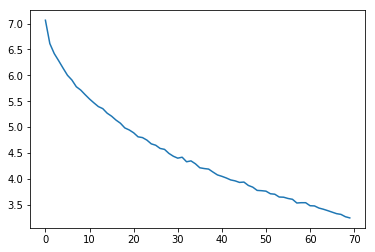

In [80]:
from matplotlib import pyplot as plt

plt.plot(train_losses)
plt.show()

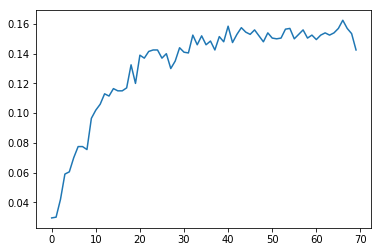

In [81]:
plt.plot(val_accs)
plt.show()

In [134]:
print('Final score:')
get_cands_accuracy(sess, data_loader)

Final score:


0.3305

In [135]:
# example
b_size=10
example_val = data_loader.sample_batch('val', b_size)
ex_hat = sess.run(a_hat, feed_dict={X:example_val[0], q:example_val[1]})

data_loader.show_example(example_val)

DOC:
so saying the fairy -lrb- that was her name -rrb- blew a little gold whistle , and a chariot appeared drawn by six splendid ostriches . in it was seated the fairy queen , escorted by a dozen other fairies mounted on dragons . all having dismounted , told her adventures , and the fairy queen approved all she had done , and proposed turning into bronze like her horse . , however , who was very kind and gentle , begged for a milder sentence , and at last it was settled that should become her slave for life unless she should have a child to take her place . the king was told of his wife 's fate and submitted to it , which , as he could do nothing to help it , was the only course open to him . the fairies then all dispersed , taking her slave with her , and on reaching her palace she said : ` you ought by rights to be scullion , but as you have been delicately brought up the change might be too great for you . i shall therefore only order you to sweep my rooms carefully , and to wash a

In [136]:
for i in range(b_size):
    print('-'*10)
    print('true:', data_loader.id_to_word[example_val[3][i]])
    cands = example_val[2][i]
    c_hat = ex_hat[i,:]
    scores = c_hat[cands]
    max_ind = np.argmax(scores)
    print('pred:', data_loader.id_to_word[cands[max_ind]], '%6.5f'%scores[max_ind])
    #for k in range(10):
    #    print(data_loader.id_to_word[cands[k]], '%6.5f'%scores[k])

----------
true: visit
pred: way 0.00559
----------
true: skin
pred: skin 0.02698
----------
true: dogs
pred: heads 0.00309
----------
true: foot
pred: witch 0.97050
----------
true: poplar
pred: world 0.00564
----------
true: merchant
pred: master 0.11641
----------
true: mother
pred: felicity 0.30863
----------
true: fairy
pred: fairy 0.00684
----------
true: crowns
pred: time 0.04293
----------
true: wrongs
pred: girl 0.00153


In [137]:
inds = ex_hat[0].argsort()[-5:][::-1]

print('Predictions:')
for ind in inds:
    print('Word:', data_loader.id_to_word[ind], '\t Score:', ex_hat[0][ind])

Predictions:
Word: lady 	 Score: 0.06037215371419625
Word: princess 	 Score: 0.05956209499265567
Word: fairy 	 Score: 0.05057825125121866
Word: room 	 Score: 0.04520066199960077
Word: palace 	 Score: 0.025044382004360113
